In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fftshift, fft2, ifftshift, ifft2
import scipy.signal as ss

def show_img(imagen_np, title=""):
    plt.imshow(imagen_np, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.show()

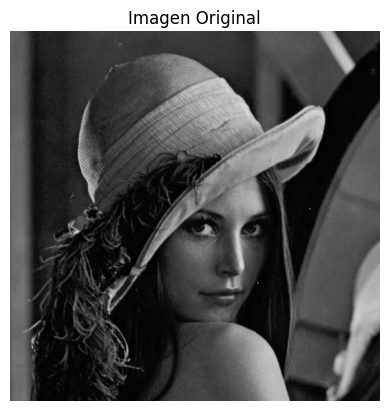

In [3]:
img_original = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)
show_img(img_original, title="Imagen Original")

In [4]:
def myBlur(img, R=10):
  ancho=img.shape[1]; alto = img.shape[0]
  dist = lambda i,j: np.sqrt((i-ancho/2)**2+(j-alto/2)**2)
  kernel = np.array([[1 if dist(i,j)<R else 0 for j in range(ancho)] for i in range(alto)])
  kernel = kernel/(np.pi*R**2)
  img_blur = np.real(fftshift(ifft2(fft2(img)*fft2(kernel))))
  return img_blur, kernel

In [5]:
# Funcion que le agrega ruido con desvio sigma a la imagen
def noise(image, std):
     return np.clip(image+np.random.normal(0, std, image.shape), 0, 255)

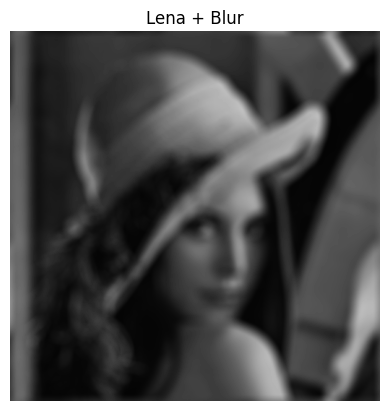

In [6]:
img_blur, h_blur = myBlur(img_original, 10)
show_img(img_blur, title="Lena + Blur")

In [7]:
MSE = lambda orig, recu: np.square(np.subtract(orig, recu)).mean()

# 1) Inverse Filtering

## a) Blur


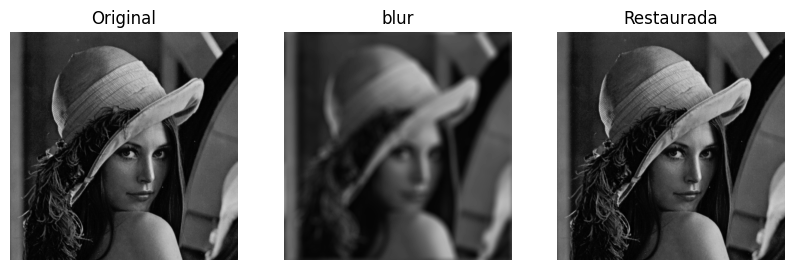

MSE con blur+noise: 292.2510455502702
MSE recuperada: 1.3824141492215957e-18


In [ ]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur
plt.subplot(1,3,2)
plt.axis(False)
plt.title('blur')
img_blur, filter_kernel = myBlur(image)
plt.imshow(img_blur, cmap='gray', vmin=0, vmax=255)

# Recuperada con Filtro inverso
fft_blur = np.fft.fft2(img_blur)
H_blur = np.fft.fft2(h_blur)
img_rep = np.real(fftshift(ifft2(fft_blur/(H_blur))))

plt.subplot(1,3,3)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(img_rep, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur:', MSE(image, img_blur))
print('MSE recuperada:', MSE(image, img_rep))

## b) Blur + Noise

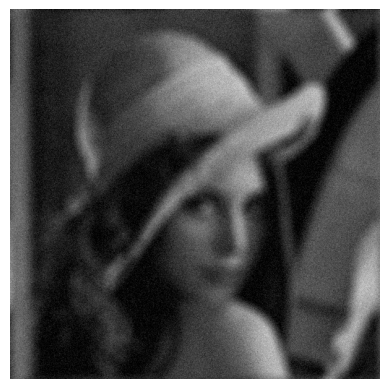

In [59]:
img_original = cv2.imread('lena_gray.tif', cv2.COLOR_BGR2GRAY)
img_Blur, _ =myBlur(img_original)
img_B_N = noise(img_Blur, 10)
show_img(img_B_N)

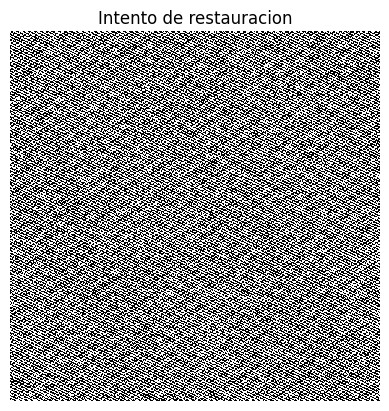

In [ ]:
fft_blur = fft2(img_BlurNoise)
H_blur = fft2(h_blur)
img_rep = np.real(fftshift(ifft2(fft_blur/(H_blur))))
show_img(img_rep, title="Intento de restauracion")

Al hacer el cociente entre la transferencia de nuestro LP y el espectro del ruido, amplificamos la potencia de ruido en altas frecuencias. Esto causa que la imagen no pueda ser recuperable con este filtro.

Si elegimos otro filtro donde la atenuación de banda de frenado sea más baja, la imagen podrá ser recuperada ya que no se atenuaría el ruido.

# 3. Blind Deconvolution

Para realizar la deconvolución ciega usamos el algoritmo de [Richardson-Lucy](https://sci-hub.se/10.1364/JOSA.62.000055) y nos basamos en su implementación realizada por [Sci-Kit](https://github.com/scikit-image/scikit-image/blob/main/skimage/restoration/deconvolution.py).

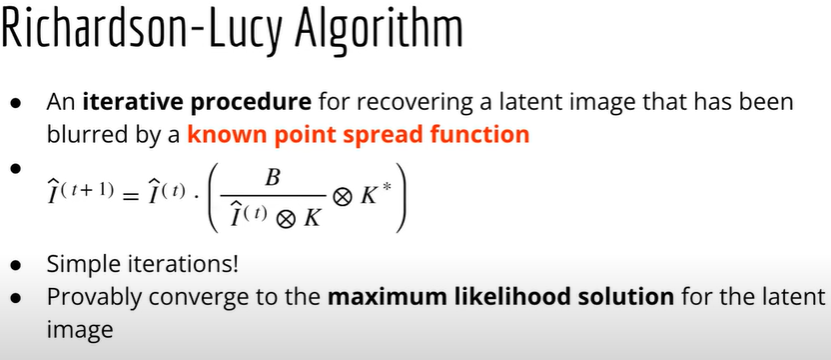


Donde $\hat{I}(t)$ es la predicción de la imagen, B la imagen desenfocada, K la PSF y K* el flip de la PSF.

Créditos de la imagen: [Xiaoyu Bi](https://www.youtube.com/watch?v=xPVisJXmSlg&t=157s&ab_channel=CMUComputationalPhotography)

In [6]:
def richardson_lucy(image, psf, num_iter=50):
    im_deconv = np.full(image.shape, 0.5)

    for _ in range(num_iter):
        relative_blur = image / ss.convolve(im_deconv, psf, mode='same')    # B/ (I(t)*K)
        im_deconv *= ss.convolve(relative_blur, np.flip(psf), mode='same')

    return np.clip(im_deconv,0,1)

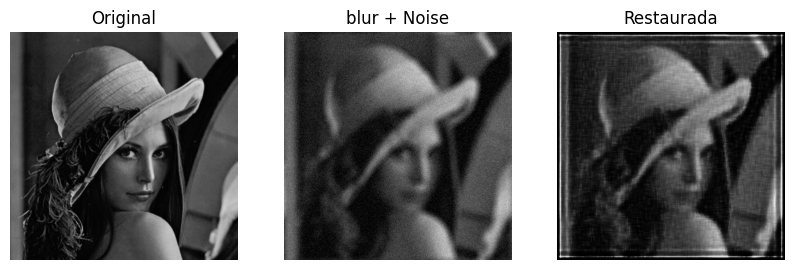

MSE con blur: 292.2510455502702
MSE recuperada: 897.5049975052181


In [17]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur + Noise
img_blur, filter_kernel = myBlur(image)
SNR = 10  # dB
img_BlurNoise = noise(img_blur, np.sqrt(np.var(img_blur) * (10**(-SNR/10))))

plt.subplot(1,3,2)
plt.axis(False)
plt.title('blur + Noise')
plt.imshow(img_BlurNoise, cmap='gray', vmin=0, vmax=255)

# Recuperada con Blind Deconv
kernel_size = 15
kernel = np.full((kernel_size,kernel_size), 1/kernel_size)
image_deconv = richardson_lucy(img_BlurNoise/255.0, kernel, num_iter=20)
image_deconv /= (np.max(image_deconv)/np.max(image))

plt.subplot(1,3,3)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(image_deconv, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur:', MSE(image, img_blur))
print('MSE recuperada:', MSE(image, image_deconv))

# 5. Regularización + Métodos iterativos

## Regularización

Recordemos el problema visto en el ejemplo de inverse filtering con ruido en donde en ciertos puntos la H(f) se volvía tan pequeña que amplificaba el N(f) tendiendo a infinito.

Las técnicas de Regularización buscan solucionar este problema de mal condicionamiento de problemas. En este informe desarrollaremos la regularización estocastica.

In [33]:
# Funcion que le agrega ruido con desvio sigma a la imagen
def noise2(image, std):
    noise = np.random.normal(0, std, image.shape)
    return np.clip(image+noise, 0, 255), noise

def stochasticReg(img, img_deg, h, noise):
  Sff = fft2(np.cov(img))
  H = fft2(h)

  num = Sff * np.conjugate(H) * fft2(img_deg)
  den = Sff * np.absolute(H)**2 + fft2(np.cov(noise))

  return ifftshift(ifft2(num / den))

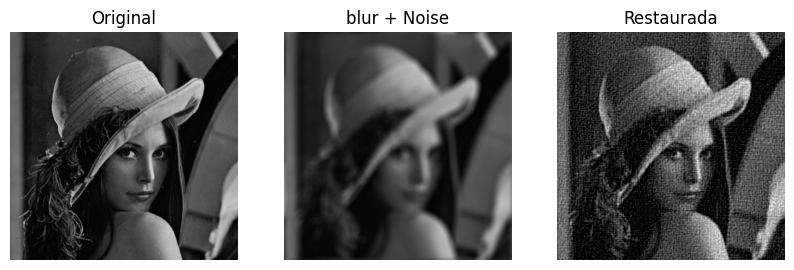

MSE con blur: 292.2510455502702
MSE recuperada: 553.156306626494


In [35]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur + Noise
img_blur, filter_kernel = myBlur(image)
SNR = 30  # dB
img_BlurNoise, noise = noise2(img_blur, np.sqrt(np.var(img_blur) * (10**(-SNR/10))))

plt.subplot(1,3,2)
plt.axis(False)
plt.title('blur + Noise')
plt.imshow(img_BlurNoise, cmap='gray', vmin=0, vmax=255)

# Recuperada con Regularizacion estocastica
image_rec = np.real(stochasticReg(image, img_BlurNoise, filter_kernel, noise))
plt.subplot(1,3,3)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(image_rec, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur:', MSE(image, img_blur))
print('MSE recuperada:', MSE(image, image_rec))

## Métodos iterativos

In [73]:
def TikhonovMiller(img_deg, h):

  C = np.array([[0,-0.25,0],[-0.25,-1,-0.25],[0,-0.25,0]])
  delta = np.zeros_like(h)
  delta[delta.shape[0]//2, delta.shape[1]//2] = 1
  C = ss.convolve2d(delta, C, mode = "same")

  H = fft2(h)

  aux = H.T*H+0.0000001*C.T*C
  eigenvalores, _= np.linalg.eig(aux)
  betta = (2/ np.abs(np.max(eigenvalores)))*0.5

  f=[]
  f.append(betta*H.T*img_deg)

  new_error = 1
  while new_error > 1e-6:
    new_f = f[-1]+ betta* (H.T*img_deg- aux*f[-1])
    f.append(new_f)
    new_error = (np.linalg.norm(f[-1]-f[-2])/np.linalg.norm(f[-2]))**2

  return f[-1]

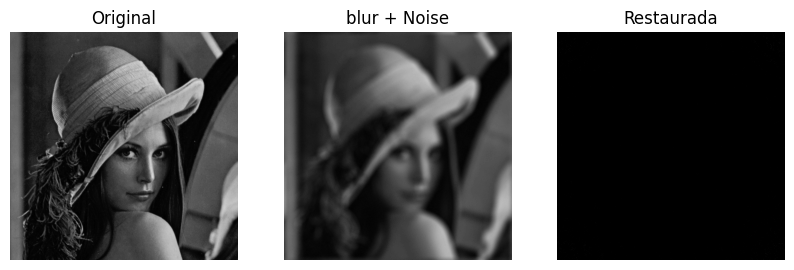

MSE con blur: 292.2510455502702
MSE recuperada: 11636.710870652967


In [74]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur + Noise
img_blur, filter_kernel = myBlur(image)
SNR = 30  # dB
img_BlurNoise, noise = noise2(img_blur, np.sqrt(np.var(img_blur) * (10**(-SNR/10))))

plt.subplot(1,3,2)
plt.axis(False)
plt.title('blur + Noise')
plt.imshow(img_BlurNoise, cmap='gray', vmin=0, vmax=255)

# Recuperada con Blind Deconv
image_rec = np.real(TikhonovMiller(img_BlurNoise, filter_kernel))
plt.subplot(1,3,3)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(image_rec, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur:', MSE(image, img_blur))
print('MSE recuperada:', MSE(image, image_rec))